In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [41]:
def load_data(train_batch_size, test_batch_size):
    train_data = torch.utils.data.DataLoader(
        datasets.CIFAR10('data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])),
        batch_size=train_batch_size, shuffle=True)

    test_data = torch.utils.data.DataLoader(
        datasets.CIFAR10('data', train=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])),
        batch_size=test_batch_size, shuffle=True)
    return (train_data, test_data)

In [42]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [43]:
train_batch_size = 100
test_batch_size = 100
train_data, test_data = load_data(train_batch_size, test_batch_size)

Files already downloaded and verified


In [44]:
def train(model, optimizer, epoch, train_data, log_interval):
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    n_correct = 0
    train_loss = 0
    counter = 0
    n_samples = 0

    for batch_idx, (data, target) in enumerate(train_data):
        counter += 1
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()

        # Forward propagation
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.data

        pred = np.argmax(output.data, axis=1)
        n_samples += target.size(0)
        n_correct += (pred == target).sum().item()
        acc = 100.0 * n_correct / n_samples

        # print log
        if batch_idx % log_interval == 0:
            print('Train set, Epoch {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_data.dataset),
                loss.data))
            print("Train Accuracy: ", round(acc,2))
    train_loss /= counter
    return train_loss, round(acc,2)


In [45]:
def test(model, epoch, test_data):
    model.eval()
    test_loss = 0
    correct = 0
    counter = 0
    n_samples = 0

    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

    for data, target in test_data:
        counter+=1
        data, target = Variable(data), Variable(target)
        
        output = model(data)
        test_loss += loss_fn(output, target).data
        n_samples += target.size(0)
        pred = np.argmax(output.data, axis=1)
        correct += (pred == target.data).sum().item()
        acc = 100.0 * correct / n_samples

    # Print log
    test_loss /= len(test_data.dataset)
    print('\nTest set, Epoch {} , Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        test_loss, correct, len(test_data.dataset),
        100. * correct / len(test_data.dataset)))
    return test_loss, round(acc,2)

In [46]:
model = CustomCNN()

lr = 0.01
momentum = 0.5
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
tr_loss_arr = []
tr_acc_arr = []
t_loss_arr = []
t_acc_arr = []

epochs = 100
log_interval = 100
for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train(model, optimizer, epoch, train_data, log_interval=log_interval)
    tr_loss_arr.append(tr_loss)
    tr_acc_arr.append(tr_acc)
    t_loss, t_acc = test(model, epoch, test_data)
    t_loss_arr.append(t_loss)
    t_acc_arr.append(t_acc)

Train set, Epoch 1 [0/50000]	Loss: 2.309937
Train Accuracy:  9.0
Train set, Epoch 1 [10000/50000]	Loss: 2.303446
Train Accuracy:  9.84
Train set, Epoch 1 [20000/50000]	Loss: 2.300292
Train Accuracy:  10.48
Train set, Epoch 1 [30000/50000]	Loss: 2.290906
Train Accuracy:  12.02
Train set, Epoch 1 [40000/50000]	Loss: 2.286041
Train Accuracy:  13.38


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set, Epoch 1 , Average loss: 2.2533, Accuracy: 1736/10000 (17%)

Train set, Epoch 2 [0/50000]	Loss: 2.253119
Train Accuracy:  16.0
Train set, Epoch 2 [10000/50000]	Loss: 2.183188
Train Accuracy:  18.09
Train set, Epoch 2 [20000/50000]	Loss: 2.127555
Train Accuracy:  19.98
Train set, Epoch 2 [30000/50000]	Loss: 2.116060
Train Accuracy:  21.28
Train set, Epoch 2 [40000/50000]	Loss: 2.034270
Train Accuracy:  22.56

Test set, Epoch 2 , Average loss: 1.9522, Accuracy: 2953/10000 (30%)

Train set, Epoch 3 [0/50000]	Loss: 1.925433
Train Accuracy:  29.0
Train set, Epoch 3 [10000/50000]	Loss: 1.845379
Train Accuracy:  30.06
Train set, Epoch 3 [20000/50000]	Loss: 1.933228
Train Accuracy:  30.82
Train set, Epoch 3 [30000/50000]	Loss: 1.775085
Train Accuracy:  31.39
Train set, Epoch 3 [40000/50000]	Loss: 1.720882
Train Accuracy:  32.34

Test set, Epoch 3 , Average loss: 1.7036, Accuracy: 3777/10000 (38%)

Train set, Epoch 4 [0/50000]	Loss: 1.770433
Train Accuracy:  36.0
Train set, Epoch 4 [1

In [47]:
loss_m_train = []
for i in tr_loss_arr:
    loss_m_train.append(i.data.numpy().tolist())

loss_m_test = []
for i in t_loss_arr:
    loss_m_test.append(i.data.numpy().tolist())


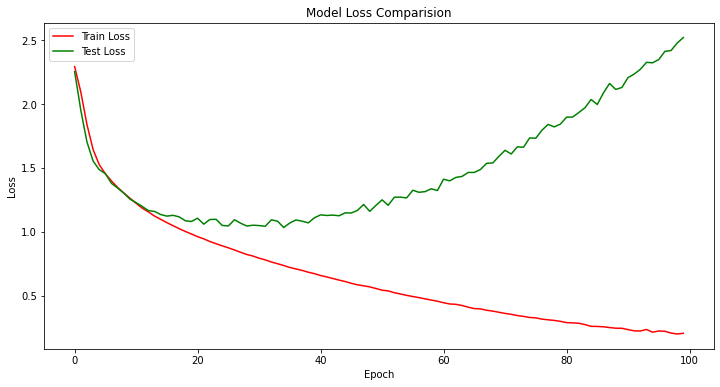

In [49]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, 100, 1), loss_m_train, color = "r")
plt.plot(np.arange(0, 100, 1), loss_m_test, color = "g")
plt.title('Model Loss Comparision')
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

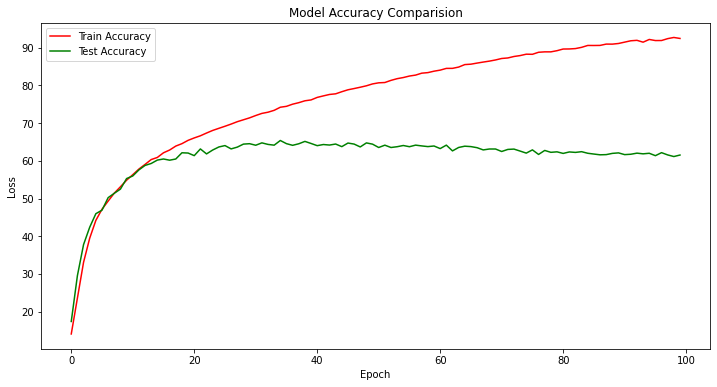

In [50]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, 100, 1), tr_acc_arr, color = "r")
plt.plot(np.arange(0, 100, 1), t_acc_arr, color = "g")
plt.title('Model Accuracy Comparision')
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()